In [1]:
import pandas as pd
import numpy as np
import spacy
import re
import nltk
import string
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process
import seaborn as sns
import matplotlib.pyplot as plt

In [184]:
import pickle
from keras.models import load_model

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [151]:
data = pd.read_csv("outfit_combinations.csv")
print(data.shape)
data.head()

(5291, 5)


,outfit_id,product_id,outfit_item_type,brand,product_full_name
0,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2P5H24WK0HTK4R0A1,bottom,Eileen Fisher,Slim Knit Skirt
1,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2PEPWFTT7RMP5AA1T,top,Eileen Fisher,Rib Mock Neck Tank
2,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2S5T9W793F4CY41HE,accessory1,kate spade new york,medium margaux leather satchel
3,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2ZFDYRYY5TRQZJTBD,shoe,Tory Burch,Penelope Mid Cap Toe Pump
4,01DMHCX50CFX5YNG99F3Y65GQW,01DMBRYVA2P5H24WK0HTK4R0A1,bottom,Eileen Fisher,Slim Knit Skirt


## Search by Product ID

In [68]:
def recommendbyID(id):
    
    #Use fuzzy-matching to find product_id that most similar to the input id
    foundID = process.extractOne(id,data['product_id'],scorer=fuzz.token_set_ratio)[0]
    
    #Get all outfit_id for which involve matched product
    outfits = data[data.product_id==foundID].outfit_id
    
    #Select first outfit
    products = data[data.outfit_id==outfits.values[0]]
    
    #Formatting output of function
    for i in products.index:
        item_type = products.loc[i,"outfit_item_type"]
        full_name = products.loc[i,"product_full_name"]
        prod_id = products.loc[i,"product_id"]
        print(item_type+": "+full_name+" ("+prod_id+")")

In [69]:
# Test
recommendbyID("01DMBRYVA2ZFDYRYY5TRQZJTCC")

bottom: Slim Knit Skirt (01DMBRYVA2P5H24WK0HTK4R0A1)
top: Rib Mock Neck Tank (01DMBRYVA2PEPWFTT7RMP5AA1T)
accessory1: medium margaux leather satchel (01DMBRYVA2S5T9W793F4CY41HE)
shoe: Penelope Mid Cap Toe Pump (01DMBRYVA2ZFDYRYY5TRQZJTBD)


## Search by free form text (description, detail, brand)

In [138]:
fd = pd.read_csv("full_data_final version.csv")
fd = fd.iloc[:,[0,1,3,4,5,10]]
print(fd.shape)
fd.head()

(48979, 6)


,product_id,brand,product_full_name,description,brand_category,details
0,01DSE9TC2DQXDG6GWKW9NMJ416,Banana Republic,Ankle-Strap Pump,"A modern pump, in a rounded silhouette with an...",Unknown,"A modern pump, in a rounded silhouette with an..."
1,01DSE9SKM19XNA6SJP36JZC065,Banana Republic,Petite Tie-Neck Top,Dress it down with jeans and sneakers or dress...,Unknown,Dress it down with jeans and sneakers or dress...
2,01DSJX8GD4DSAP76SPR85HRCMN,Loewe,52MM Padded Leather Round Sunglasses,Padded leather covers classic round sunglasses.,JewelryAccessories/SunglassesReaders/RoundOval...,100% UV protection Case and cleaning cloth inc...
3,01DSJVKJNS6F4KQ1QM6YYK9AW2,Converse,Baby's & Little Kid's All-Star Two-Tone Mid-To...,The iconic mid-top design gets an added dose o...,"JustKids/Shoes/Baby024Months/BabyGirl,JustKids...",Canvas upper Round toe Lace-up vamp SmartFOAM ...
4,01DSK15ZD4D5A0QXA8NSD25YXE,Alexander McQueen,64MM Rimless Sunglasses,Hexagonal shades offer a rimless view with int...,JewelryAccessories/SunglassesReaders/RoundOval,100% UV protection Gradient lenses Adjustable ...


In [16]:
merge = fd.merge(data,left_on='product_id',right_on='product_id',how="inner")
merge.drop_duplicates(inplace=True)
merge = merge.loc[:,["product_id","outfit_id","outfit_item_type","brand_x","product_full_name_x","description","details"]]
merge.rename(columns={"brand_x": "brand", "product_full_name_x": "product_full_name"}, inplace=True)
print(merge.shape)
merge.head()

(5484, 7)


,product_id,outfit_id,outfit_item_type,brand,product_full_name,description,details
0,01DVA59VHYAPT4PVX32NXW91G5,01DVA879D7TQ59VPTTGCMJWWSK,shoe,Tibi,Juan Embossed Mules,Tibi's Juan embossed mules are made from shiny...,As seen on the Pre-Fall ‘19 runway Heel measur...
2,01DVA4XY7A0QMMSK3V3SBR52J9,01DVA8GAYP45BCEMYGEK7FXGDQ,shoe,Alexandre Birman,Clarita Bow-Embellished Suede Sandals,Alexandre Birman's 'Clarita' sandals have quic...,Heel height measures approximately 50mm / 2 in...
3,01DVA4XY7A0QMMSK3V3SBR52J9,01DWJE4FDNYRV6ZJBG25HJFYY2,shoe,Alexandre Birman,Clarita Bow-Embellished Suede Sandals,Alexandre Birman's 'Clarita' sandals have quic...,Heel height measures approximately 50mm / 2 in...
6,01DVBP9AHVQTZXJSBNJ0N2NYJP,01DVBPKBK15VKQYKXV1YWR5PZ1,shoe,Khaite,Leather ankle boots,Heel measures approximately 50mm/ 2 inches Bla...,"Fits true to size, take your normal size Ital..."
7,01DVBP9AHVQTZXJSBNJ0N2NYJP,01DVBPKBK1CN1AMKDTSKJKGY7S,shoe,Khaite,Leather ankle boots,Heel measures approximately 50mm/ 2 inches Bla...,"Fits true to size, take your normal size Ital..."


In [17]:
merge.isnull().sum()

product_id             0
outfit_id              0
outfit_item_type       0
brand                  0
product_full_name      0
description          144
details              628
dtype: int64

#### Preprocess

In [139]:
fd = fd.replace(np.nan, 'UNKNOWN_TOKEN', regex=True)
fd['details'] = fd['details'].str.replace("\n", "")
fd['text'] = fd['description']+' '+fd['details']+' '+fd['brand']+fd["brand_category"]

In [18]:
# Concat text fields 
merge= merge.replace(np.nan, 'UNKNOWN_TOKEN', regex=True)
merge['details'] = merge['details'].str.replace("\n", "")
merge['text'] = merge['description']+' '+merge['details']+' '+merge['brand']

In [19]:
nlp = spacy.load('en_core_web_md')

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    #remove stopwords and do lemmatization
    doc = nlp(sentence)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return " ".join(tokens)

In [20]:
merge['text'] = merge['text'].apply(preprocess_text)

In [140]:
fd['text'] = fd['text'].apply(preprocess_text)

#### Vectorization: TF-IDF

In [141]:
doc = list(fd['text'].values)

In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase =True,
                             stop_words='english',
                             min_df=3, 
                             max_df=0.9,
                             token_pattern=r'\w{3,}')
tfidf_vector = vectorizer.fit_transform(doc)
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=vectorizer.get_feature_names(),index = fd.product_id)
tfidf_df

,aaa,aarke,aarkehomehitech,abalone,abbreviate,ability,able,abloh,ablohwomen,abo,...,zodiac,zoe,zoejustkids,zone,zoom,zoomx,zwilling,zwillinger,zwillingerwomen,zyl
product_id,,,,,,,,,,,,,,,,,,,,,
01DSE9TC2DQXDG6GWKW9NMJ416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01DSE9SKM19XNA6SJP36JZC065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01DSJX8GD4DSAP76SPR85HRCMN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01DSJVKJNS6F4KQ1QM6YYK9AW2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01DSK15ZD4D5A0QXA8NSD25YXE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01DSNVXY8EJ9FQAJ3MPDMPASHD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01DSGYHA3RMCHENBJVQPBGXM97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01DSJT8H12CAFQQH07SQSQWJ8C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
save_obj(vectorizer, "tfidf_vectorizer")

Number of components = 2000 and explained variance = 0.8273051338038762
Number of components = 2100 and explained variance = 0.8359934145078515
Number of components = 2200 and explained variance = 0.8441443836744487
Number of components = 2300 and explained variance = 0.8518141680492417
Number of components = 2400 and explained variance = 0.8590610994214056
Number of components = 2500 and explained variance = 0.8658673731879033
Number of components = 2600 and explained variance = 0.8723034915649722
Number of components = 2700 and explained variance = 0.8783522991905641
Number of components = 2800 and explained variance = 0.8840770035150987
Number of components = 2900 and explained variance = 0.8894702819915883
Number of components = 3000 and explained variance = 0.8945627069301569


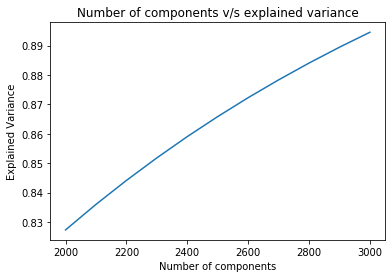

In [149]:
# Reduce Dimension: SVD (Visualization) → explain why we choose n_components
from sklearn.decomposition import TruncatedSVD
n_comp = [2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]
explained = [] 
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(tfidf_vector)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Number of components v/s explained variance")
plt.show()

In [150]:
svd = TruncatedSVD(n_components=3000)
reduced = svd.fit_transform(tfidf_vector)
reduced_df = pd.DataFrame(reduced,index = fd.product_id)
reduced_df.reset_index(inplace = True)

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
product_id,,,,,,,,,,,,,,,,,,,,,
01DSE9TC2DQXDG6GWKW9NMJ416,0.100486,0.118782,0.162039,-0.013858,-0.036473,-0.006007,-0.042595,-0.062756,0.050070,-0.059289,...,-0.000710,-0.000518,0.000716,0.001937,0.002031,0.000870,0.001900,0.001179,-0.000089,-0.003123
01DSE9SKM19XNA6SJP36JZC065,0.225083,-0.009894,-0.005734,-0.064319,0.045148,-0.089217,-0.108043,0.024490,0.046607,0.000735,...,-0.000252,0.001636,-0.001216,0.002241,-0.000336,0.002406,-0.002913,-0.001173,0.002367,0.001029
01DSJX8GD4DSAP76SPR85HRCMN,0.134094,0.505115,-0.321900,0.180120,-0.042768,0.077333,-0.037870,-0.047457,-0.036754,-0.012890,...,-0.002565,0.000458,-0.002619,-0.005172,-0.010835,-0.001184,0.006752,0.019198,0.015948,0.018913
01DSJVKJNS6F4KQ1QM6YYK9AW2,0.127241,0.067609,0.280106,0.284850,0.087744,0.041988,-0.072867,-0.009981,-0.100061,-0.023790,...,-0.006028,0.000525,0.000517,-0.013915,0.008348,0.004295,-0.000518,-0.007090,-0.007038,0.010403
01DSK15ZD4D5A0QXA8NSD25YXE,0.094381,0.369618,-0.291163,0.130229,-0.003939,0.074940,-0.043405,-0.048438,-0.054056,0.008898,...,-0.000818,0.003469,0.014925,0.000960,-0.005307,-0.002740,-0.010204,0.005887,0.010585,0.003241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01DSNVXY8EJ9FQAJ3MPDMPASHD,0.320402,-0.124313,-0.013624,0.143987,0.066887,0.032485,0.085218,-0.011865,-0.020075,-0.084190,...,-0.012063,0.007156,-0.005503,-0.006279,-0.005097,-0.015895,0.004549,-0.000045,0.006262,-0.005088
01DSGYHA3RMCHENBJVQPBGXM97,0.075420,0.018714,0.011088,-0.038372,0.022543,-0.046989,-0.010499,-0.008954,0.034962,-0.052821,...,0.000823,0.003906,0.003487,-0.003841,-0.002741,-0.019491,-0.013913,0.005423,-0.005919,0.005147
01DSJT8H12CAFQQH07SQSQWJ8C,0.261926,-0.135735,0.014489,0.244414,0.219129,-0.026623,-0.081503,-0.007915,0.014339,0.049343,...,-0.001969,0.004386,-0.001469,-0.005731,0.003569,-0.002080,0.001032,-0.000792,-0.001352,-0.000799


In [186]:
save_obj(svd, "SVD")

In [176]:
merge = pd.merge(data,reduced_df,how='left',left_on="product_id", right_on = 'product_id')
merge.set_index("product_id", inplace=True)

In [181]:
import scipy
def similarproduct(query):
    query = preprocess_text(query)
    query_vector = vectorizer.transform([query])
    query_vector = svd.transform(query_vector)
    cos = 0
    for i in range(len(merge)):
        similar = 1 - scipy.spatial.distance.cosine(query_vector, merge.iloc[i,4:])
        if similar > cos:
            cos = similar
            productid = merge.index[i]
    return recommendbyID(productid)

In [182]:
# Test on Example B
similarproduct("slim fitting, straight leg pant with a center back zipper and slightly cropped leg Reformation")

accessory1: Cassi Belt Bag (01DPEHS0XH9PDD1GH5ZE4P43A2)
bottom: Marlon Pant (01DPKMH0D252JKMAA27MFCT5GM)
top: Jane Sweater (01DPKN20Q3J0BE3CS896DQB6ER)
shoe: Giulia Satin Heel (01DPKNHQDG6GPTKV97CFQRJDHE)


In [183]:
# Test Example C
similarproduct("Sexy silky, a-line mini skirt zipper Benson skirt")

shoe: Pointed-toe flats in suede (01DPCRZWX4S2Z8Q5HYDFM4HNEG)
top: Ashlynn Blouse (01DPET2NWSA221STZF740BZ9SW)
bottom: Benson Skirt (01DPKMGJ33SDFXM7XHGPQJWQ12)


In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
def getvectors(doc):
    vectorizer = TfidfVectorizer(lowercase =True,stop_words='english')
    tfidf_vector = vectorizer.fit_transform(doc)
    n_comp = [10,20,50,100,150,200,300,400,500,700,800]
    explained = 0
    for x in n_comp:
        svd = TruncatedSVD(n_components=x)
        svd.fit(tfidf_vector)
        explained = svd.explained_variance_ratio_.sum()
        if explained > 0.9:
            break
    svd = TruncatedSVD(n_components=x)
    reduced = svd.fit_transform(tfidf_vector)
    return reduced

In [116]:
reduced = getvectors(doc)

In [117]:
reduced_df = pd.DataFrame(reduced,index = merge.product_id)

In [118]:
import scipy
def similarproduct(query):
    query = preprocess_text(query)
    query_vector = vectorizer.transform([query])
    query_vector = svd.transform(query_vector)
    cos = 0
    for i in range(len(reduced_df)):
        similar = 1 - scipy.spatial.distance.cosine(query_vector, reduced[i])
        if similar > cos:
            cos = similar
            productid = reduced_df.index[i]
    return recommendbyID(productid)

In [119]:
# Test Example B
similarproduct("slim fitting, straight leg pant with a center back zipper and slightly cropped leg Reformation")

accessory1: Cassi Belt Bag (01DPEHS0XH9PDD1GH5ZE4P43A2)
bottom: Marlon Pant (01DPKMH0D252JKMAA27MFCT5GM)
top: Jane Sweater (01DPKN20Q3J0BE3CS896DQB6ER)
shoe: Giulia Satin Heel (01DPKNHQDG6GPTKV97CFQRJDHE)


In [121]:
# Test Example C
similarproduct("Sexy silky, a-line mini skirt zipper Benson skirt")

shoe: Pointed-toe flats in suede (01DPCRZWX4S2Z8Q5HYDFM4HNEG)
top: Ashlynn Blouse (01DPET2NWSA221STZF740BZ9SW)
bottom: Benson Skirt (01DPKMGJ33SDFXM7XHGPQJWQ12)


In [120]:
## Separate steps

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase =True,
                             stop_words='english')
tfidf_vector = vectorizer.fit_transform(doc)
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=vectorizer.get_feature_names(),index = merge.product_id)
tfidf_df

,ab,abbreviate,abe,abloh,abs,absence,absolute,absorb,abstract,accent,...,zebra,zelander,zella,zeynep,zimmermann,zip,zipped,zipper,zombie,zoom
product_id,,,,,,,,,,,,,,,,,,,,,
01DVA59VHYAPT4PVX32NXW91G5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01DVA4XY7A0QMMSK3V3SBR52J9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01DVA4XY7A0QMMSK3V3SBR52J9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01DVBP9AHVQTZXJSBNJ0N2NYJP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01DVBP9AHVQTZXJSBNJ0N2NYJP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01E2M3YP5BRH2FNMZ6386PBPCM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01E2M3YP5BRH2FNMZ6386PBPCM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01E2M3YP5BRH2FNMZ6386PBPCM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Number of components = 10 and explained variance = 0.18134492084342493
Number of components = 20 and explained variance = 0.2573300825041583
Number of components = 50 and explained variance = 0.4039139002742996
Number of components = 100 and explained variance = 0.5631300334292677
Number of components = 150 and explained variance = 0.672777896192039
Number of components = 200 and explained variance = 0.7520192575898446
Number of components = 300 and explained variance = 0.8584987117373426
Number of components = 400 and explained variance = 0.9231685133381264
Number of components = 500 and explained variance = 0.960894541447213
Number of components = 700 and explained variance = 0.9941818859753706
Number of components = 800 and explained variance = 0.9999838829667007


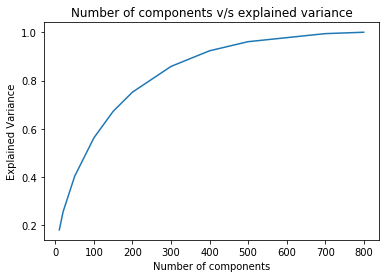

In [134]:
# Reduce Dimension: SVD (Visualization) → explain why we choose n_components
from sklearn.decomposition import TruncatedSVD
n_comp = [10,20,50,100,150,200,300,400,500,700,800]
explained = [] 
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(tfidf_vector)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Number of components v/s explained variance")
plt.show()

In [98]:
svd = TruncatedSVD(n_components=400)
reduced = svd.fit_transform(tfidf_vector)
reduced_df = pd.DataFrame(reduced,index = merge.product_id)
reduced_df

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
product_id,,,,,,,,,,,,,,,,,,,,,
01DVA59VHYAPT4PVX32NXW91G5,0.201952,0.246490,-0.068436,-0.089528,-0.049681,-0.008854,0.036381,0.070748,0.056076,0.020062,...,0.014987,-0.001293,-0.079958,-0.006341,0.063492,-0.032924,0.053190,0.036256,-0.011828,-0.016178
01DVA4XY7A0QMMSK3V3SBR52J9,0.150073,0.197747,-0.047333,-0.110845,-0.069754,0.001990,-0.016368,0.049697,0.060271,-0.003265,...,-0.052895,-0.026448,-0.002017,-0.007952,0.014787,-0.021240,0.031911,0.039542,-0.051607,-0.006640
01DVA4XY7A0QMMSK3V3SBR52J9,0.150073,0.197747,-0.047333,-0.110845,-0.069754,0.001990,-0.016368,0.049697,0.060271,-0.003265,...,-0.052895,-0.026448,-0.002017,-0.007952,0.014787,-0.021240,0.031911,0.039542,-0.051607,-0.006640
01DVBP9AHVQTZXJSBNJ0N2NYJP,0.371784,0.534057,-0.313227,0.081043,-0.094971,0.023239,0.020014,-0.049296,0.017396,-0.058670,...,0.014506,0.005650,-0.016849,-0.009888,-0.011103,-0.010149,0.004446,-0.017784,0.000862,0.017286
01DVBP9AHVQTZXJSBNJ0N2NYJP,0.371784,0.534057,-0.313227,0.081043,-0.094971,0.023239,0.020014,-0.049296,0.017396,-0.058670,...,0.014506,0.005650,-0.016849,-0.009888,-0.011103,-0.010149,0.004446,-0.017784,0.000862,0.017286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01E2M3YP5BRH2FNMZ6386PBPCM,0.121303,-0.036861,-0.016376,-0.031559,0.016168,0.065480,-0.013219,-0.057902,-0.089439,0.166496,...,0.047089,0.062604,-0.043015,0.002432,0.015637,-0.046787,0.031285,-0.023392,0.009501,-0.015670
01E2M3YP5BRH2FNMZ6386PBPCM,0.121303,-0.036861,-0.016376,-0.031559,0.016168,0.065480,-0.013219,-0.057902,-0.089439,0.166496,...,0.047089,0.062604,-0.043015,0.002432,0.015637,-0.046787,0.031285,-0.023392,0.009501,-0.015670
01E2M3YP5BRH2FNMZ6386PBPCM,0.121303,-0.036861,-0.016376,-0.031559,0.016168,0.065480,-0.013219,-0.057902,-0.089439,0.166496,...,0.047089,0.062604,-0.043015,0.002432,0.015637,-0.046787,0.031285,-0.023392,0.009501,-0.015670


In [110]:
import scipy
def similarproduct(query):
    query = preprocess_text(query)
    query_vector = vectorizer.transform([query])
    query_vector = svd.transform(query_vector)
    cos = 0
    for i in range(len(reduced_df)):
        similar = 1 - scipy.spatial.distance.cosine(query_vector, reduced[i])
        if similar > cos:
            cos = similar
            productid = reduced_df.index[i]
    return recommendbyID(productid)

In [111]:
# Test on Example B
similarproduct("slim fitting, straight leg pant with a center back zipper and slightly cropped leg Reformation")

accessory1: Cassi Belt Bag (01DPEHS0XH9PDD1GH5ZE4P43A2)
bottom: Marlon Pant (01DPKMH0D252JKMAA27MFCT5GM)
top: Jane Sweater (01DPKN20Q3J0BE3CS896DQB6ER)
shoe: Giulia Satin Heel (01DPKNHQDG6GPTKV97CFQRJDHE)


#### Vectorization: Count Vectorize

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vector = vectorizer.fit_transform(doc)
count_df = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names(),index = merge.product_id)
count_df

,ab,abbreviate,abe,abloh,abs,absence,absolute,absorb,abstract,accent,...,zebra,zelander,zella,zeynep,zimmermann,zip,zipped,zipper,zombie,zoom
product_id,,,,,,,,,,,,,,,,,,,,,
01DVA59VHYAPT4PVX32NXW91G5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01DVA4XY7A0QMMSK3V3SBR52J9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01DVA4XY7A0QMMSK3V3SBR52J9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01DVBP9AHVQTZXJSBNJ0N2NYJP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01DVBP9AHVQTZXJSBNJ0N2NYJP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01E2M3YP5BRH2FNMZ6386PBPCM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01E2M3YP5BRH2FNMZ6386PBPCM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01E2M3YP5BRH2FNMZ6386PBPCM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Number of components = 10 and explained variance = 0.34472195436727066
Number of components = 20 and explained variance = 0.450416559998154
Number of components = 50 and explained variance = 0.61445511703826
Number of components = 100 and explained variance = 0.7529008636659935
Number of components = 150 and explained variance = 0.8313859608758696
Number of components = 200 and explained variance = 0.8824061251082932
Number of components = 300 and explained variance = 0.9419883630823818
Number of components = 400 and explained variance = 0.9719527178509122
Number of components = 500 and explained variance = 0.9872534412601137
Number of components = 700 and explained variance = 0.998575457989091
Number of components = 800 and explained variance = 0.9999967567766785


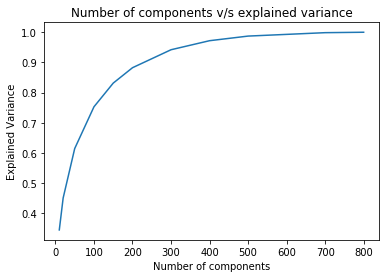

In [133]:
n_comp = [10,20,50,100,150,200,300,400,500,700,800]
explained = [] 
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(vector)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Number of components v/s explained variance")
plt.show()

In [92]:
svd = TruncatedSVD(n_components=200)
reduced2 = svd.fit_transform(vector)
reduced_df2 = pd.DataFrame(reduced2,index = merge.product_id)
reduced_df2

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
product_id,,,,,,,,,,,,,,,,,,,,,
01DVA59VHYAPT4PVX32NXW91G5,2.931253,2.131596,2.369533,1.584679,-0.501728,0.233304,-0.104894,0.166904,-0.286669,-0.183682,...,-0.072783,-0.197871,0.051731,-0.130292,-0.266214,-0.146097,0.158061,-0.076632,0.056733,0.083207
01DVA4XY7A0QMMSK3V3SBR52J9,2.464141,2.312433,1.509188,2.130192,-0.425334,0.193713,0.027142,0.409817,-0.903305,-0.367370,...,0.331093,-0.592148,0.043957,-0.005600,-0.130309,-0.274399,-0.143556,0.076465,0.150628,0.022581
01DVA4XY7A0QMMSK3V3SBR52J9,2.464141,2.312433,1.509188,2.130192,-0.425334,0.193713,0.027142,0.409817,-0.903305,-0.367370,...,0.331093,-0.592148,0.043957,-0.005600,-0.130309,-0.274399,-0.143556,0.076465,0.150628,0.022581
01DVBP9AHVQTZXJSBNJ0N2NYJP,2.349354,0.717511,2.374940,0.864906,-0.741487,0.916697,0.797791,-0.049740,-0.109095,0.436183,...,0.058828,0.215033,0.188512,0.001215,-0.092512,0.042025,0.026676,-0.055404,-0.261237,0.105980
01DVBP9AHVQTZXJSBNJ0N2NYJP,2.349354,0.717511,2.374940,0.864906,-0.741487,0.916697,0.797791,-0.049740,-0.109095,0.436183,...,0.058828,0.215033,0.188512,0.001215,-0.092512,0.042025,0.026676,-0.055404,-0.261237,0.105980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01E2M3YP5BRH2FNMZ6386PBPCM,1.408756,-0.331106,0.418548,0.080631,0.315384,-0.045213,0.213893,0.082678,-0.067931,-0.460116,...,-0.163904,-0.029217,-0.071957,-0.019443,0.021806,0.214523,-0.045183,-0.079264,0.167853,-0.285324
01E2M3YP5BRH2FNMZ6386PBPCM,1.408756,-0.331106,0.418548,0.080631,0.315384,-0.045213,0.213893,0.082678,-0.067931,-0.460116,...,-0.163904,-0.029217,-0.071957,-0.019443,0.021806,0.214523,-0.045183,-0.079264,0.167853,-0.285324
01E2M3YP5BRH2FNMZ6386PBPCM,1.408756,-0.331106,0.418548,0.080631,0.315384,-0.045213,0.213893,0.082678,-0.067931,-0.460116,...,-0.163904,-0.029217,-0.071957,-0.019443,0.021806,0.214523,-0.045183,-0.079264,0.167853,-0.285324


In [93]:
def similarproduct2(query):
    query = preprocess_text(query)
    query_vector = vectorizer.transform([query])
    query_vector = svd.transform(query_vector)
    cos = 0
    for i in range(len(reduced_df2)):
        similar = 1 - scipy.spatial.distance.cosine(query_vector, reduced2[i])
        if similar > cos:
            cos = similar
            productid = reduced_df2.index[i]
    return recommendbyID(productid)

In [94]:
similarproduct2("slim fitting, straight leg pant with a center back zipper and slightly cropped leg Reformation")

accessory1: Cassi Belt Bag (01DPEHS0XH9PDD1GH5ZE4P43A2)
bottom: Marlon Pant (01DPKMH0D252JKMAA27MFCT5GM)
top: Jane Sweater (01DPKN20Q3J0BE3CS896DQB6ER)
shoe: Giulia Satin Heel (01DPKNHQDG6GPTKV97CFQRJDHE)
